In [1]:
import numpy as np
from matplotlib import pyplot as plt
from function_main import *

In [13]:
def ET_CRB(sigma1, sigma2, n_a, n_q, observ=sim): #M=1 !
    teta_samp = samp_teta(observ)
    G = np.ones((n_q*M,M))
    g_teta = G @ teta_samp
    zeta_real = ((math.sqrt(2)/sigma2)*(g_teta.real))
    zeta_im = ((math.sqrt(2)/sigma2)*(g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    d_vec = ((n_q*rho_q)/(2*pow(sigma2, 2)))*(np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im)))))
    
    return np.mean(1/(1+(rho_a * n_a / pow(sigma1, 2))+d_vec[:1,:]*np.abs(G[0,:])**2)) #M=1 ! 

def weighted_fun(theta_real,theta_imag,sigma1,sigma2,na,nq):
    zeta_real = (math.sqrt(2) / sigma2) * (theta_real)
    zeta_im = (math.sqrt(2) / sigma2) * (theta_imag)
    d = norm.pdf(zeta_real)**2/(norm.cdf(zeta_real)*(norm.cdf(-zeta_real)))+norm.pdf(zeta_im)**2/(norm.cdf(zeta_im)*(norm.cdf(-zeta_im)))
    return 1/(1+na/(sigma1**2)+(nq*d)/(2*sigma2**2))

def div_weighted(theta,sigma1,sigma2,na,nq):
    zeta_real = (math.sqrt(2) / sigma2) * ((theta).real)
    zeta_im = (math.sqrt(2) / sigma2) * ((theta).imag)
    d = (norm.pdf(zeta_real)**2/(norm.cdf(zeta_real)*(norm.cdf(-zeta_real))))+(norm.pdf(zeta_im)**2/(norm.cdf(zeta_im)*(norm.cdf(-zeta_im))))
    c1,c2,c3 = 2*sigma1**2*sigma2**2, na*sigma2**2+2*sigma1**2*sigma2**2,nq*sigma1**2 
    divv_d_real = ((-math.sqrt(2)*norm.pdf(zeta_real)**2)/sigma2)*(2*theta.real*norm.cdf(zeta_real)*(norm.cdf(-zeta_real))+
                                norm.pdf(zeta_real)*(1-2*norm.pdf(zeta_real)))/(norm.cdf(zeta_real)*(norm.cdf(-zeta_real)))**2
    divv_d_imag = ((-math.sqrt(2)*norm.pdf(zeta_im)**2)/sigma2)*(2*theta.imag*norm.cdf(zeta_im)*(norm.cdf(-zeta_im))+
                                        norm.pdf(zeta_im)*(1-2*norm.pdf(zeta_im)))/(norm.cdf(zeta_im)*(norm.cdf(-zeta_im)))**2
    return 0.5*(((-c1*c3*divv_d_real)/(c2+c3*d)**2)-1j*((-c1*c3*divv_d_imag)/(c2+c3*d)**2))

def weighted_BCRB(sigma1,sigma2,n_a,n_q,monte,thresh_real=0,thresh_im=0):
    monte2=500
    delta=1e-5
    result = np.zeros((monte)) 
    weighted_vec = np.zeros((monte))
    theta_org = samp_teta(monte)[0]
    for j in range(monte):
        matrix=[np.ones((n_a*M,M)),np.ones((n_q*M,M))]
        theta_real,theta_imag = theta_org[j].real,theta_org[j].imag
        theta = theta_real+1j*theta_imag
        weighted = weighted_fun(theta_real,theta_imag,sigma1,sigma2,n_a,n_q)
        weighted_vec[j] = weighted
        result2 = np.zeros((monte2))
        for i in range(monte2):
            x_a,x_q = x(sigma1,sigma2, n_a,n_q, matrix,theta)
            zeta_real = (math.sqrt(2) / sigma2) * ((matrix[1] * theta).real - thresh_real)
            zeta_im = (math.sqrt(2) / sigma2) * ((matrix[1] * theta).imag - thresh_im)
            logP_x_q = np.sum(((((norm.pdf(zeta_real)/(norm.cdf(zeta_real)*(-norm.cdf(-zeta_real))))*
                              (norm.cdf(zeta_real)-0.5-x_q.real.reshape(n_q,M)/math.sqrt(2))))
                              -1j*(((norm.pdf(zeta_im)/(norm.cdf(zeta_im)*(-norm.cdf(-zeta_im))))*
                              (norm.cdf(zeta_im)-0.5-x_q.imag.reshape(n_q,M)/math.sqrt(2)))))*(1/(sigma2*math.sqrt(2))),0)
            logf = -theta.conjugate()+matrix[0].transpose()@(x_a.reshape(n_a,M)-matrix[0]*theta).conjugate()/(sigma1**2)+logP_x_q
            divv =0.5*(((weighted_fun(theta_real+delta,theta_imag,sigma1,sigma2,n_a,n_q)-weighted)/delta)-1j*((weighted_fun(theta_real,theta_imag+delta,sigma1,sigma2,n_a,n_q)-weighted)/delta))#div_weighted(theta,sigma1,sigma2,n_a,n_q)
            result2[i] = np.abs(divv+weighted*logf)**2
        result[j] = np.mean(result2)
    return np.abs(np.mean(weighted_vec))**2/np.mean(result)

# weighted_BCRB(1,1,1,40,100)

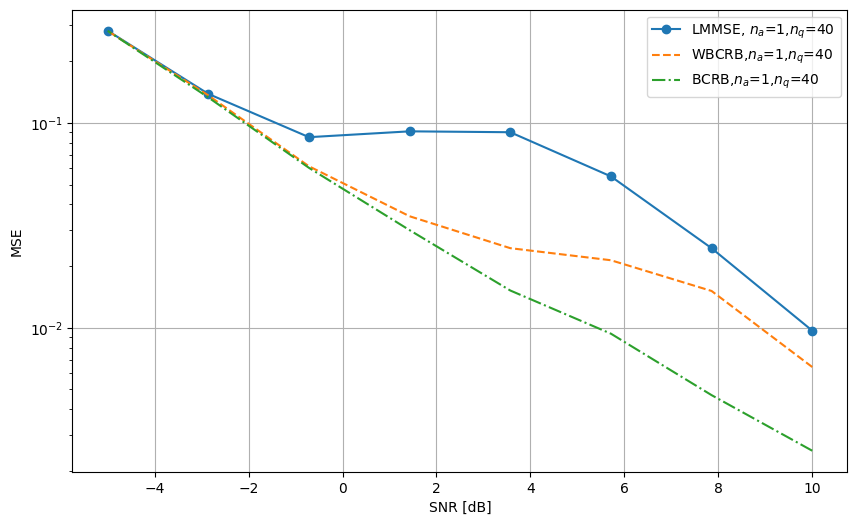

In [15]:
sigma_space_new = np.logspace(-1,0.5,8)
na=1
nq=40
matrix_const1 = Matrix(na,nq)
L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na,nq) for i in range(len(sigma_space_new))]
ET_CRB1 = [weighted_BCRB(sigma_space_new[i],sigma_space_new[i],na,nq,100) for i in range(len(sigma_space_new))]
CRB1 = [CRB(sigma_space_new[i],sigma_space_new[i],na,nq,matrix_const1,500) for i in range(len(sigma_space_new))]
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic1, marker="o", label = r"LMMSE, $n_a$={},$n_q$={}".format(na,nq))
plt.plot(10*np.log10(1/sigma_space_new), ET_CRB1,linestyle='--', label = r"WBCRB,$n_a$={},$n_q$={}".format(na,nq)) 
plt.plot(10*np.log10(1/sigma_space_new), CRB1,linestyle='-.', label = r"BCRB,$n_a$={},$n_q$={}".format(na,nq))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

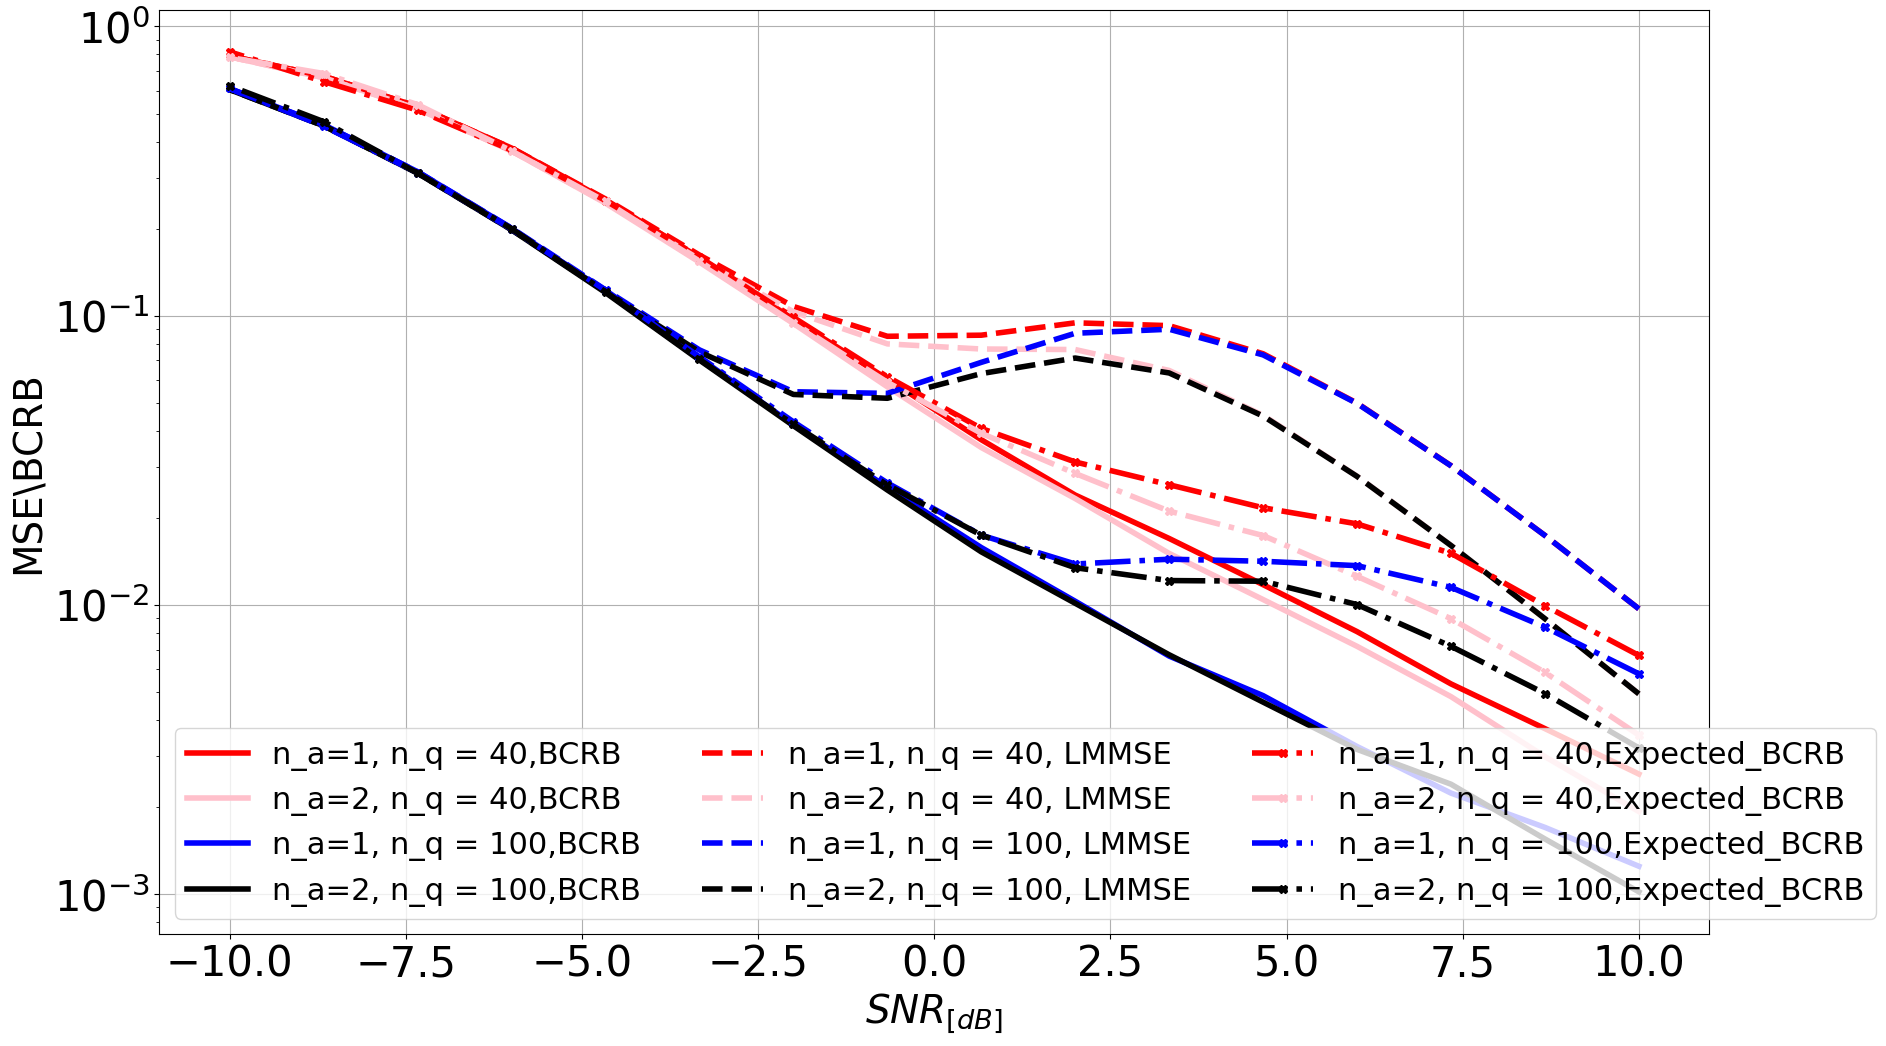

In [18]:
sigma_space = np.logspace(-1,1,16)

n_a = [1,2,1,2]
n_q = [40,40,100,100]
matrix_const1 = Matrix(n_a[0],n_q[0])
matrix_const2 = Matrix(n_a[1],n_q[1])
matrix_const3 = Matrix(n_a[2],n_q[2])
matrix_const4 = Matrix(n_a[3],n_q[3])
thresh_real = thresh_G(n_q[0],matrix_const1[1])[0]
thresh_imag = thresh_G(n_q[0],matrix_const1[1])[1]
thresh_const = np.ones((M*n_q[0], 1))
expected_value_sim = 500
snapshots = 3000
bound_sim = 1000 
w_bound_sim = 500


L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[0],n_q[0]) for i in range(len(sigma_space))]
L_Estimator_analytic2 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[1],n_q[1]) for i in range(len(sigma_space))]
L_Estimator_analytic3 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[2],n_q[2]) for i in range(len(sigma_space))]
L_Estimator_analytic4 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[3],n_q[3]) for i in range(len(sigma_space))]

CRB1 = [CRB(sigma_space[i],sigma_space[i],n_a[0],n_q[0],matrix_const1,500) for i in range(len(sigma_space))]
CRB2 = [CRB(sigma_space[i],sigma_space[i],n_a[1],n_q[1],matrix_const2,500) for i in range(len(sigma_space))]
CRB3 = [CRB(sigma_space[i],sigma_space[i],n_a[2],n_q[2],matrix_const3,500) for i in range(len(sigma_space))]
CRB4 = [CRB(sigma_space[i],sigma_space[i],n_a[3],n_q[3],matrix_const4,500) for i in range(len(sigma_space))]

NEWCRB1 = [weighted_BCRB(sigma_space[i],sigma_space[i],n_a[0],n_q[0],w_bound_sim) for i in range(len(sigma_space))]
NEWCRB2 = [weighted_BCRB(sigma_space[i],sigma_space[i],n_a[1],n_q[1],w_bound_sim) for i in range(len(sigma_space))]
NEWCRB3 = [weighted_BCRB(sigma_space[i],sigma_space[i],n_a[2],n_q[2],w_bound_sim) for i in range(len(sigma_space))]
NEWCRB4 = [weighted_BCRB(sigma_space[i],sigma_space[i],n_a[3],n_q[3],w_bound_sim) for i in range(len(sigma_space))]

######################
fig = plt.figure(figsize=(20, 12))
list_of_colors = ['red','pink','blue','black']

list_of_functions = [CRB1,CRB2,CRB3,CRB4]
for i in range(len(list_of_functions)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions[i] ,color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {},BCRB'.format(n_a[i], n_q[i]))

list_of_functions1 = [L_Estimator_analytic1, L_Estimator_analytic2,L_Estimator_analytic3,L_Estimator_analytic4]
for i in range(len(list_of_functions1)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions1[i],'--', color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {}, LMMSE'.format(n_a[i], n_q[i]))

list_of_functions2 = [NEWCRB1,NEWCRB2,NEWCRB3,NEWCRB4]
for i in range(len(list_of_functions2)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions2[i],'-.',marker="X",color=list_of_colors[i],linewidth=4, label=r'n_a={}, n_q = {},Expected_BCRB'.format(n_a[i], n_q[i]))
# ax = plt.gca()
# ax.set_xticks(np.arange(-3.6,8,0.5), minor=True)
# ax.grid(which='major', alpha=1)
# ax.grid(which='minor',linestyle="--",alpha=0.5)

# plt.xlim(-3.6, 8)
plt.grid()
plt.yscale('log')
plt.ylabel('MSE\BCRB',fontsize=28)
plt.xlabel(r"$SNR_{[dB]}$",fontsize=28)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=22, loc='lower left', ncol=3)
plt.show()

In [38]:
# for i in range(len(list_of_functions2)):
#     np.save(f"WBCRB{i}".format(i),list_of_functions2[i])
np.save("WBCRB1",list_of_functions2[0])

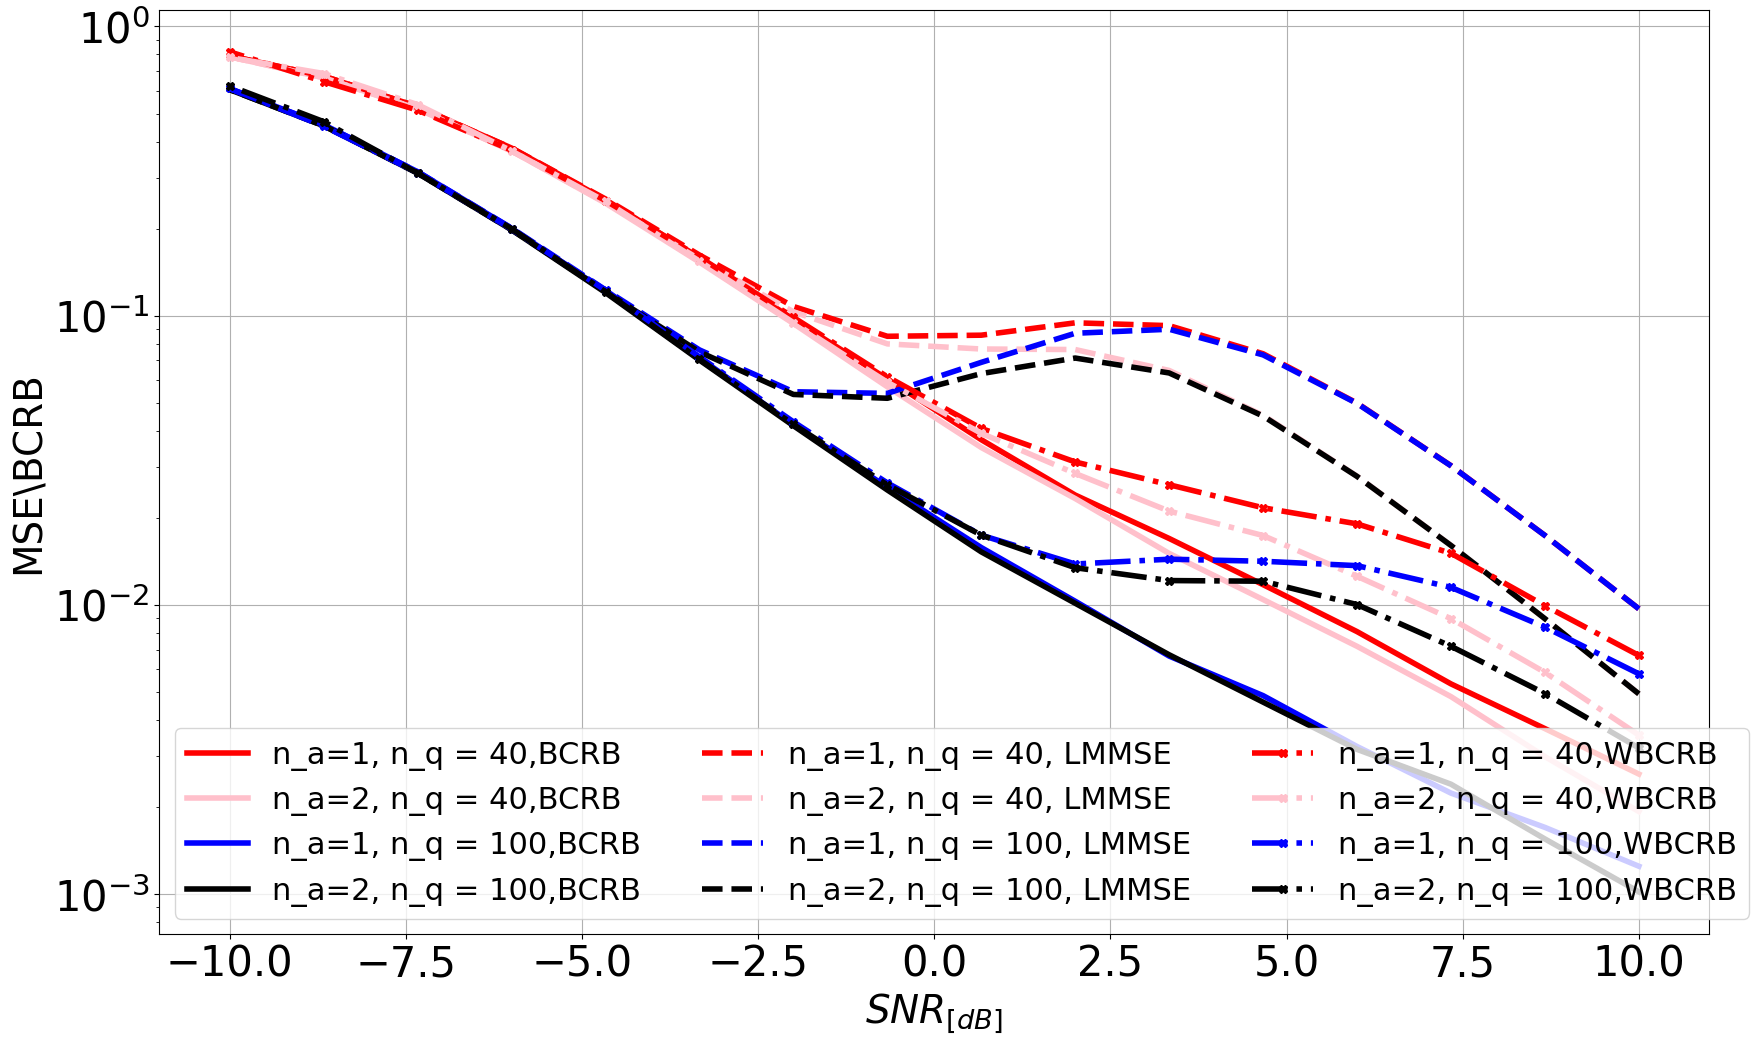

In [19]:
######################
fig = plt.figure(figsize=(20, 12))
list_of_colors = ['red','pink','blue','black']

list_of_functions = [CRB1,CRB2,CRB3,CRB4]
for i in range(len(list_of_functions)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions[i] ,color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {},BCRB'.format(n_a[i], n_q[i]))

list_of_functions1 = [L_Estimator_analytic1, L_Estimator_analytic2,L_Estimator_analytic3,L_Estimator_analytic4]
for i in range(len(list_of_functions1)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions1[i],'--', color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {}, LMMSE'.format(n_a[i], n_q[i]))

list_of_functions2 = [NEWCRB1,NEWCRB2,NEWCRB3,NEWCRB4]
for i in range(len(list_of_functions2)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions2[i],'-.',marker="X",color=list_of_colors[i],linewidth=4, label=r'n_a={}, n_q = {},WBCRB'.format(n_a[i], n_q[i]))
# ax = plt.gca()
# ax.set_xticks(np.arange(-3.6,8,0.5), minor=True)
# ax.grid(which='major', alpha=1)
# ax.grid(which='minor',linestyle="--",alpha=0.5)

# plt.xlim(-3.6, 8)
plt.grid()
plt.yscale('log')
plt.ylabel('MSE\BCRB',fontsize=28)
plt.xlabel(r"$SNR_{[dB]}$",fontsize=28)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=22, loc='lower left', ncol=3)
plt.show()

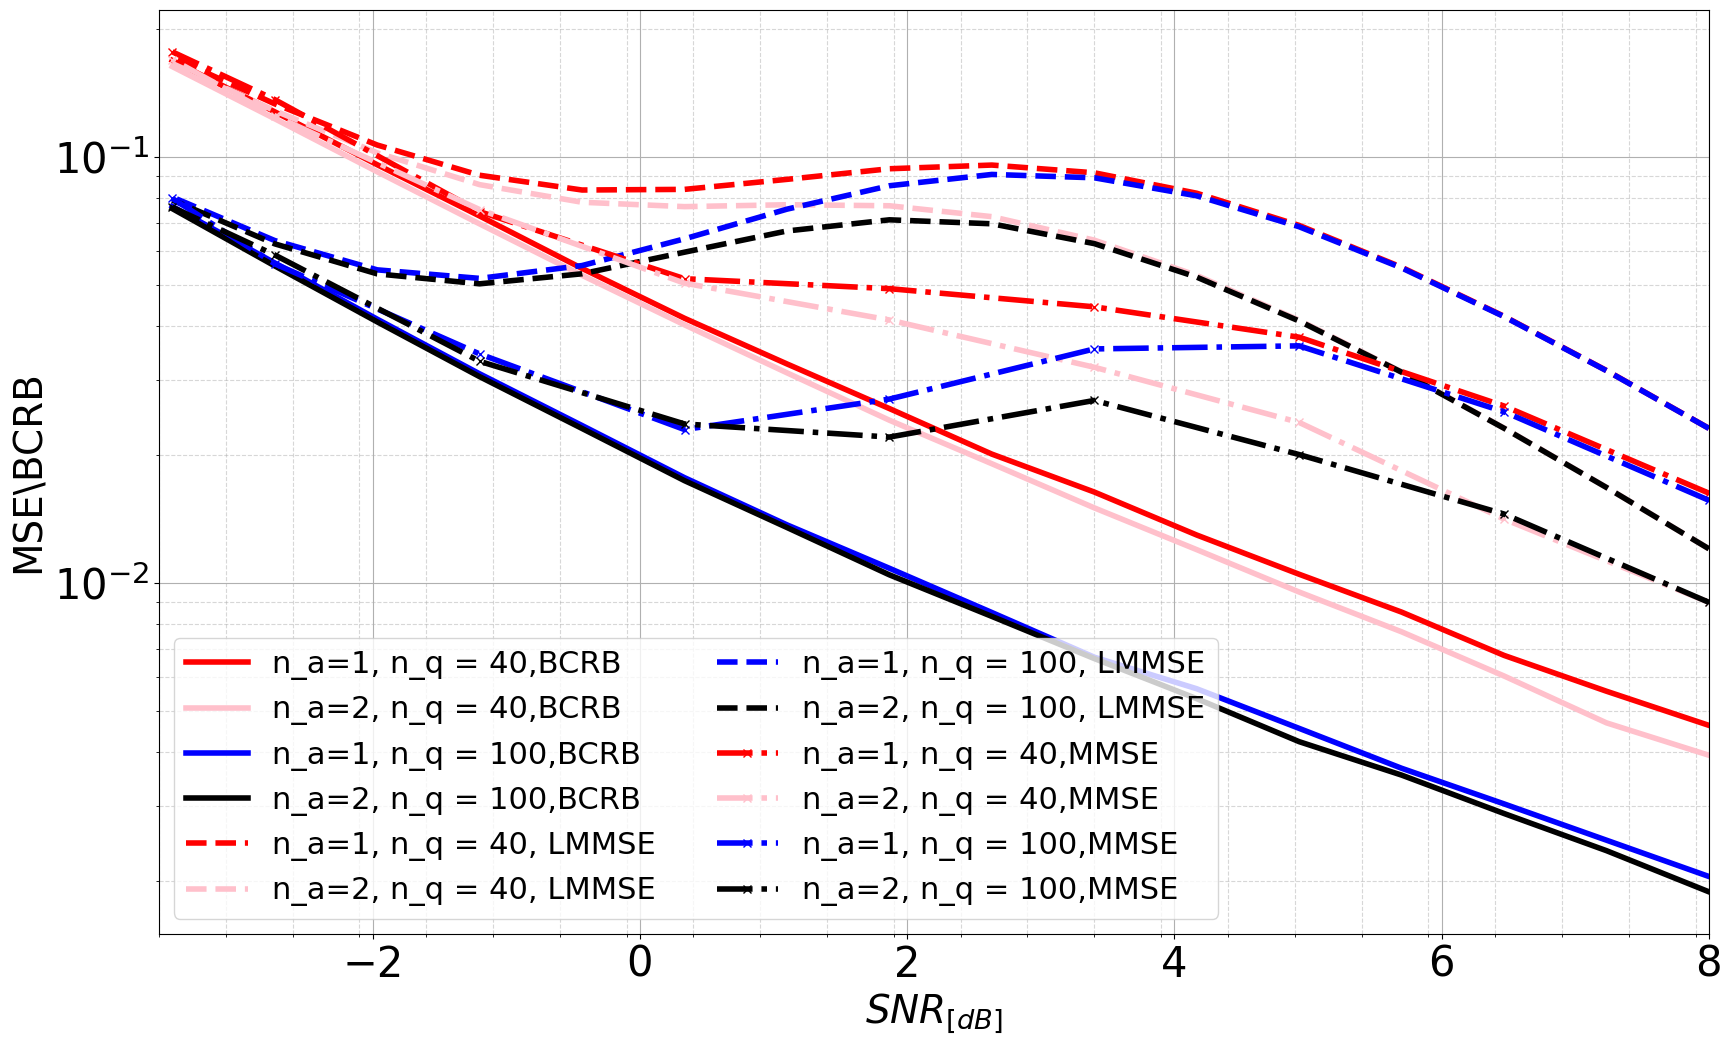

In [7]:
sigma_space = np.logspace(-0.8,0.35,16)

n_a = [1,2,1,2]
n_q = [40,40,100,100]
matrix_const1 = Matrix(n_a[0],n_q[0])
matrix_const2 = Matrix(n_a[1],n_q[1])
matrix_const3 = Matrix(n_a[2],n_q[2])
matrix_const4 = Matrix(n_a[3],n_q[3])
thresh_real = thresh_G(n_q[0],matrix_const1[1])[0]
thresh_imag = thresh_G(n_q[0],matrix_const1[1])[1]
thresh_const = np.ones((M*n_q[0], 1))
expected_value_sim = 500
snapshots = 3000
bound_sim = 2500

L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[0],n_q[0]) for i in range(len(sigma_space))]
L_Estimator_analytic2 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[1],n_q[1]) for i in range(len(sigma_space))]
L_Estimator_analytic3 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[2],n_q[2]) for i in range(len(sigma_space))]
L_Estimator_analytic4 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[3],n_q[3]) for i in range(len(sigma_space))]

CRB1 = [CRB(sigma_space[i],sigma_space[i],n_a[0],n_q[0],matrix_const1,1,bound_sim) for i in range(len(sigma_space))]
CRB2 = [CRB(sigma_space[i],sigma_space[i],n_a[1],n_q[1],matrix_const2,1,bound_sim) for i in range(len(sigma_space))]
CRB3 = [CRB(sigma_space[i],sigma_space[i],n_a[2],n_q[2],matrix_const3,1,bound_sim) for i in range(len(sigma_space))]
CRB4 = [CRB(sigma_space[i],sigma_space[i],n_a[3],n_q[3],matrix_const4,1,bound_sim) for i in range(len(sigma_space))]

CRBpp_1 =  np.load(f"expected_value/E_value,na=1,nq=40,snap=10000,monte=500.npy")#[E_theta_givenx_numeric(sigma_space[i],sigma_space[i],n_a[0],n_q[0],matrix_const1,snapshots,expected_value_sim) for i in range(len(sigma_space))]
CRBpp_2 = np.load(f"expected_value/E_value,na=2,nq=40,snap=11000,monte=600.npy")#[E_theta_givenx_numeric(sigma_space[i],sigma_space[i],n_a[1],n_q[1],matrix_const2,snapshots,expected_value_sim) for i in range(len(sigma_space))]
CRBpp_3 = np.load(f"expected_value/E_value,na=1,nq=100,snap=10000,monte=500.npy")#[E_theta_givenx_numeric(sigma_space[i],sigma_space[i],n_a[2],n_q[2],matrix_const3,snapshots,expected_value_sim) for i in range(len(sigma_space))]
CRBpp_4 = np.load(f"expected_value/E_value,na=2,nq=100,snap=11000,monte=600.npy")#[E_theta_givenx_numeric(sigma_space[i],sigma_space[i],n_a[3],n_q[3],matrix_const4,snapshots,expected_value_sim) for i in range(len(sigma_space))]

######################
fig = plt.figure(figsize=(20, 12))
list_of_colors = ['red','pink','blue','black']

list_of_functions = [CRB1,CRB2,CRB3,CRB4]
for i in range(len(list_of_functions)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions[i] ,color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {},BCRB'.format(n_a[i], n_q[i]))

list_of_functions1 = [L_Estimator_analytic1, L_Estimator_analytic2,L_Estimator_analytic3,L_Estimator_analytic4]
for i in range(len(list_of_functions1)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions1[i],'--', color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {}, LMMSE'.format(n_a[i], n_q[i]))

list_of_colors = ['red','pink','blue','black']
list_of_functions2 = [CRBpp_1,CRBpp_2,CRBpp_3,CRBpp_4]
for i in range(len(list_of_functions2)):
    plt.plot(np.concatenate((10*np.log10(1/sigma_space)[::2],np.array([10*np.log10(1/sigma_space)[-1]]))), np.concatenate((list_of_functions2[i][::2],np.array([list_of_functions2[i][-1]]))),'-.',marker="x",color=list_of_colors[i],linewidth=4, label=r'n_a={}, n_q = {},MMSE'.format(n_a[i], n_q[i]))

ax = plt.gca()
ax.set_xticks(np.arange(-3.6,8,0.5), minor=True)
ax.grid(which='major', alpha=1)
ax.grid(which='minor',linestyle="--",alpha=0.5)

plt.xlim(-3.6, 8)
plt.yscale('log')
plt.ylabel('MSE\BCRB',fontsize=28)
plt.xlabel(r"$SNR_{[dB]}$",fontsize=28)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=22, loc='lower left', ncol=2)
plt.show()

* Threshold :

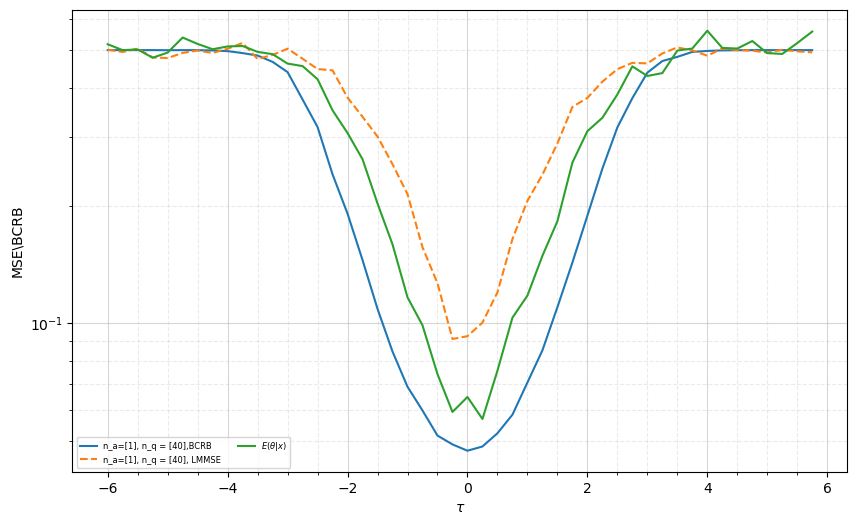

In [3]:
new_sim=1000
new_snap=3000
thresh_space1 = np.arange(-6,6,0.25)
n_a = [1]
n_q = [40]
matrix_const1 = Matrix(n_a[0],n_q[0])
sigma = 1
L_Estimator_numerical1 = [MSE_general_numerical(sigma,sigma, n_a[0],n_q[0],matrix_const1, new_sim,new_snap,thresh_space1[i]*np.ones((M*n_q[0], 1)),thresh_space1[i]*np.ones((M*n_q[0], 1))) for i in range(len(thresh_space1))]
CRB1 = [CRB(1,1,n_a[0],n_q[0],matrix_const1,1,new_sim,thresh_space1[i]**np.ones((M*n_q[0], 1)),thresh_space1[i]*np.ones((M*n_q[0], 1))) for i in range(len(thresh_space1))]
E_given = np.load(f"expected_value/E_value_thresh,na=1,nq=40,snap=5000,monte=500.npy")

fig = plt.figure(figsize=(10, 6))
plt.plot(thresh_space1, CRB1 , label='n_a={}, n_q = {},BCRB'.format(n_a, n_q))
plt.plot(thresh_space1, L_Estimator_numerical1, '--', label='n_a={}, n_q = {}, LMMSE'.format(n_a, n_q))
plt.plot(thresh_space1, E_given,label=r'$E(\theta|x)$')
plt.yscale('log')
ax = plt.gca()
ax.set_xticks(np.arange(-6,6,0.5), minor=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor',linestyle="--",alpha=0.25)
plt.ylabel('MSE\BCRB',fontsize=10)
plt.xlabel(r"$\tau$")
plt.legend(fontsize=6, loc='lower left', ncol=2)
plt.show()

In [5]:
new_sim=500
new_snap=3000
my_range = np.arange(0,5.5,0.5)
thresh_space1 = my_range
n_a = [1,2,1,2]
n_q = [40,40,100,100]
matrix_const1 = Matrix(n_a[0],n_q[0])
matrix_const2 = Matrix(n_a[1],n_q[1])
matrix_const3 = Matrix(n_a[2],n_q[2])
matrix_const4 = Matrix(n_a[3],n_q[3])
sigma = 1

# L_Estimator_numerical1 = [MSE_general_numerical(sigma,sigma, n_a[0],n_q[0],matrix_const1, new_sim,new_snap,thresh_space1[i]*np.ones((M*n_q[0], 1)),thresh_space1[i]*np.ones((M*n_q[0], 1))) for i in range(len(thresh_space1))]
# L_Estimator_numerical2 = [MSE_general_numerical(sigma,sigma, n_a[1],n_q[1],matrix_const2, new_sim,new_snap,thresh_space1[i]*np.ones((M*n_q[1], 1)),thresh_space1[i]*np.ones((M*n_q[1], 1))) for i in range(len(thresh_space1))]
# L_Estimator_numerical3 = [MSE_general_numerical(sigma,sigma, n_a[2],n_q[2],matrix_const3, new_sim,new_snap,thresh_space1[i]*np.ones((M*n_q[2], 1)),thresh_space1[i]*np.ones((M*n_q[2], 1))) for i in range(len(thresh_space1))]
# L_Estimator_numerical4 = [MSE_general_numerical(sigma,sigma, n_a[3],n_q[3],matrix_const4, new_sim,new_snap,thresh_space1[i]*np.ones((M*n_q[3], 1)),thresh_space1[i]*np.ones((M*n_q[3], 1))) for i in range(len(thresh_space1))]
# list_of_functions1 = [L_Estimator_numerical1, L_Estimator_numerical2,L_Estimator_numerical3,L_Estimator_numerical4]
# for i in range(len(list_of_functions)):
#     np.save(f"PNLE,na={n_a[i]},nq={n_q[i]},snap={snapshots},monte={expected_value_sim}",list_of_functions1[i])
L_Estimator_numerical1 = np.load(f"numeric_thresh/PNLE,na=1,nq=40,snap=3000,monte=500.npy")[11:]
L_Estimator_numerical2 = np.load(f"numeric_thresh/PNLE,na=2,nq=40,snap=3000,monte=500.npy")[11:]
L_Estimator_numerical3 = np.load(f"numeric_thresh/PNLE,na=1,nq=100,snap=3000,monte=500.npy")[11:]
L_Estimator_numerical4 = np.load(f"numeric_thresh/PNLE,na=2,nq=100,snap=3000,monte=500.npy")[11:]
E_given1 = np.load(f"expected_value/E_value_thresh,na=1,nq=40,snap=5000,monte=500.npy")[::2][1:-1][11:]
E_given2 = np.load(f"expected_value/E_value_thresh,na=2,nq=40,snap=5000,monte=500.npy")[::2][1:-1][11:]
E_given3 = np.load(f"expected_value/E_value_thresh,na=1,nq=100,snap=5000,monte=500.npy")[::2][1:-1][11:]
E_given4 = np.load(f"expected_value/E_value_thresh,na=2,nq=100,snap=5000,monte=500.npy")[::2][1:-1][11:]

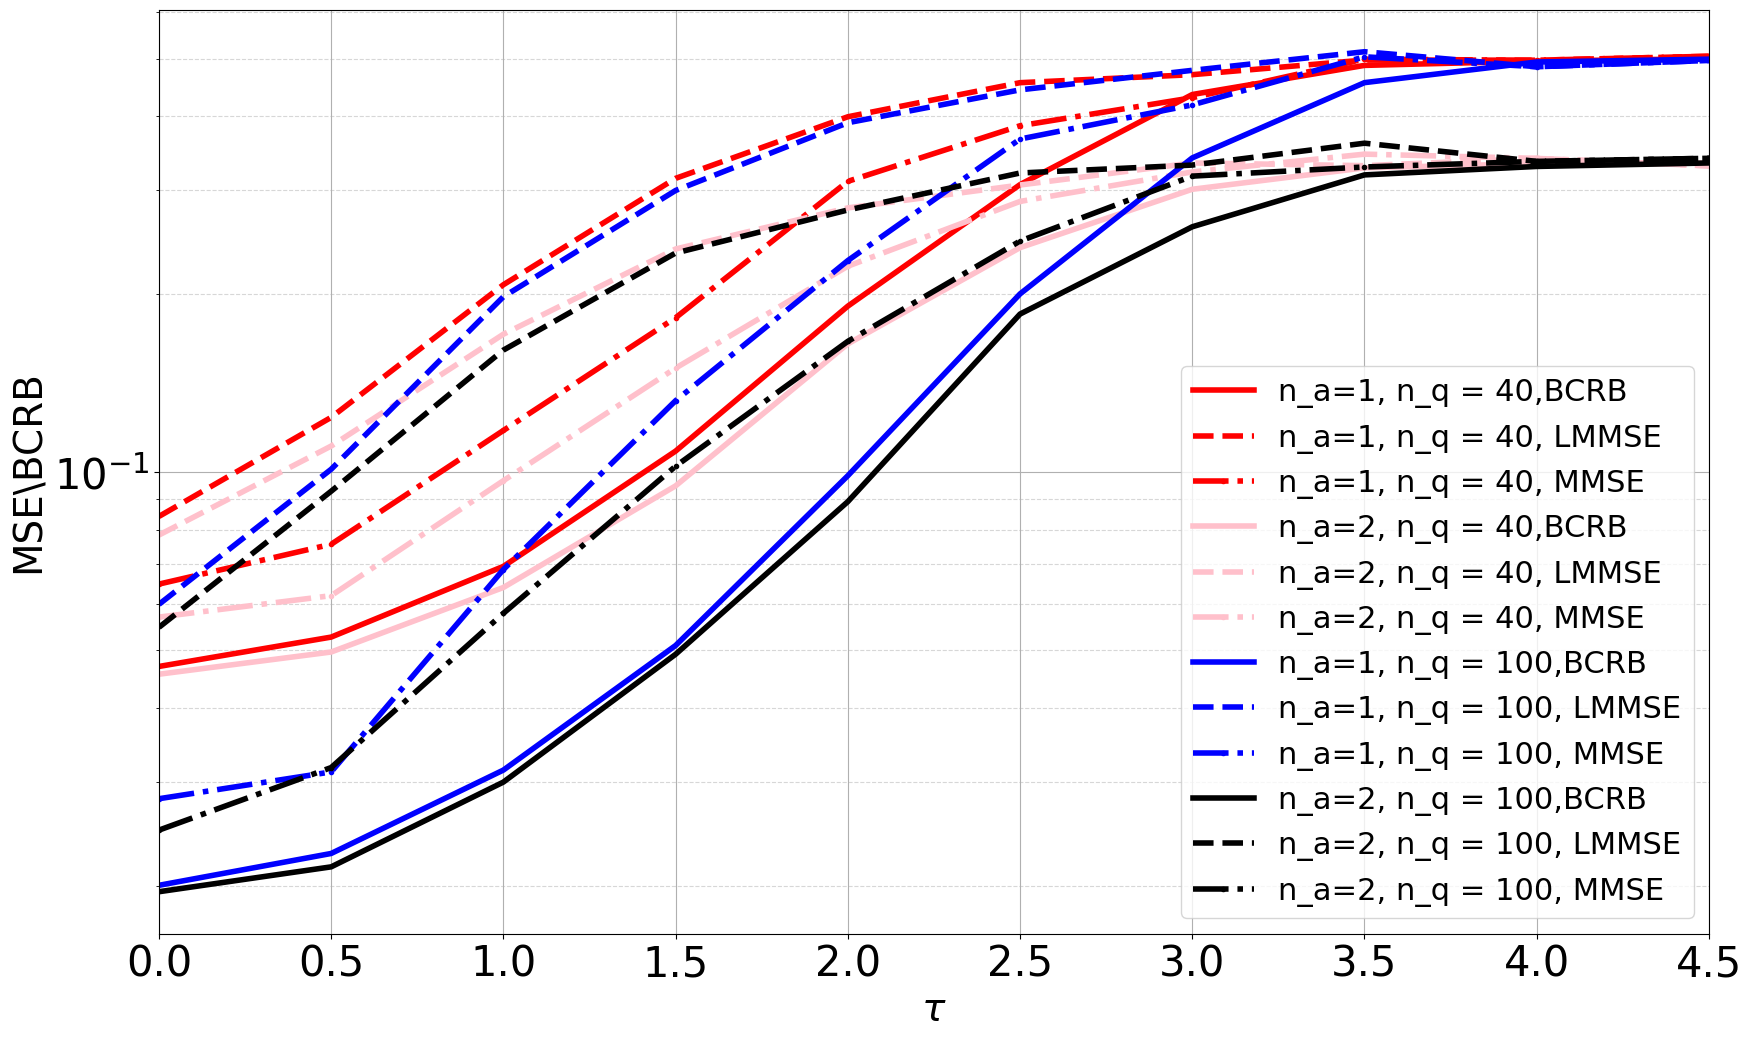

In [6]:
CRB1 = [CRB(1,1,n_a[0],n_q[0],matrix_const1,1,new_sim,thresh_space1[i]**np.ones((M*n_q[0], 1)),thresh_space1[i]*np.ones((M*n_q[0], 1))) for i in range(len(thresh_space1))]
CRB2 = [CRB(1,1,n_a[1],n_q[1],matrix_const2,1,new_sim,thresh_space1[i]**np.ones((M*n_q[1], 1)),thresh_space1[i]*np.ones((M*n_q[1], 1))) for i in range(len(thresh_space1))]
CRB3 = [CRB(1,1,n_a[2],n_q[2],matrix_const3,1,new_sim,thresh_space1[i]**np.ones((M*n_q[2], 1)),thresh_space1[i]*np.ones((M*n_q[2], 1))) for i in range(len(thresh_space1))]
CRB4 = [CRB(1,1,n_a[3],n_q[3],matrix_const4,1,new_sim,thresh_space1[i]**np.ones((M*n_q[3], 1)),thresh_space1[i]*np.ones((M*n_q[3], 1))) for i in range(len(thresh_space1))]
######################
fig = plt.figure(figsize=(20, 12))
list_of_colors = ['red','pink','blue','black']
list_of_functions = [CRB1,CRB2,CRB3,CRB4]
list_of_functions1 = [L_Estimator_numerical1, L_Estimator_numerical2,L_Estimator_numerical3,L_Estimator_numerical4]
list_of_functions2 = [E_given1,E_given2,E_given3,E_given4]
for i in range(len(list_of_functions)):
    # list_of_functions2[i][:4]=list_of_functions1[i][:4]
    list_of_functions2[i][-3:]=list_of_functions1[i][-3:]

for i in range(len(list_of_functions)):
    plt.plot(thresh_space1, list_of_functions[i] ,color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {},BCRB'.format(n_a[i], n_q[i]))
    plt.plot(thresh_space1, list_of_functions1[i], '--',color=list_of_colors[i],linewidth=4, label='n_a={}, n_q = {}, LMMSE'.format(n_a[i], n_q[i]))
    plt.plot(thresh_space1, list_of_functions2[i], '-..',color=list_of_colors[i],linewidth=4, label=r'n_a={}, n_q = {}, MMSE'.format(n_a[i], n_q[i]))
    
    # cubic_interpolation_model = interp1d(thresh_space1, list_of_functions1[i], kind="cubic")
    # X_ = np.linspace(thresh_space1.min(), thresh_space1.max(), 40)
    # Y_ = cubic_interpolation_model(X_)
    # plt.plot(X_, Y_, color=list_of_colors[i],label='n_a={}, n_q = {}, Numerical'.format(n_a[i], n_q[i]))
    # X_Y_Spline = make_interp_spline(thresh_space1, list_of_functions1[i])
    # X_ = np.linspace(thresh_space1.min(), thresh_space1.max(), 50)
    # Y_ = X_Y_Spline(X_)
    # plt.plot(X_, Y_, color=list_of_colors[i],label='n_a={}, n_q = {}, Numerical'.format(n_a[i], n_q[i]))
plt.yscale('log')
ax = plt.gca()
ax.set_xticks(np.arange(0,5,0.5), minor=True)
ax.grid(which='major', alpha=1)
ax.grid(which='minor',linestyle="--",alpha=0.5)

plt.xlim(0, 4.5)
plt.ylabel('MSE\BCRB',fontsize=28)
plt.xlabel(r"$\tau$",fontsize=28)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=22, loc='lower right', ncol=1)

# axins1 = ax.inset_axes([0.75, 0.25, 0.12, 0.15]) #size and location #TODO- the size
# axins1.plot(thresh_space1, L_Estimator_numerical2, linestyle='--',color='pink', label='Sample 1')
# axins1.plot(thresh_space1, L_Estimator_numerical3, linestyle='--',color='blue', label='Sample 2')
# # axins1.legend(loc='upper left',fontsize=6)
# axins1.yaxis.set_visible(False)
# axins1.xaxis.set_visible(False)
# down = 0.115
# delta_ver=0.02
# left = 0.52
# delta_hori = 0.2
# x1, x2, y1, y2 = left, left+delta_hori, down, down+delta_ver
# axins1.set_xlim(x1, x2)
# axins1.set_ylim(y1, y2)
# ax.indicate_inset_zoom(axins1)

plt.show()

Partiall linear:

In [ ]:
# def PL(sigma1,sigma2, n_a, n_q, matrix, observ,thresh_real=0, thresh_imag=0): #TODO
#     MSE = np.zeros((observ, M, M))
# 
#     x_a_vec, x_q_vec, teta_vec = samp(sigma1,sigma2, n_a,n_q, matrix,int(5e4),thresh_real,thresh_imag)
#     cov_teta_xq = covariance(teta_vec,x_q_vec)
#     cov_xq = covariance(x_q_vec,x_q_vec) #np.cov(x_q_vec) #Nq X Nq
#     if np.linalg.det(cov_xq) == 0: #check if K is singular
#         U,S,V = np.linalg.svd(cov_xq)
#         S[S<epsilon] = epsilon
#         K = U@np.diag(S)@V #K+epsilon*np.identity(K.shape[0])
#     cov_xq_inv = LA.inv(cov_xq)
# 
#     for i in range(observ):
#         real_teta = np.random.normal(mu, sigma_teta,M)
#         im_teta = np.random.normal(mu, sigma_teta,M)
#         teta = real_teta + 1j*im_teta
#         teta = teta.reshape(M,1)
#         x_a, x_q = x(sigma1,sigma2, n_a, n_q, matrix,teta,thresh_real,thresh_imag)  # function of teta
#         mu_tilda_real = mu*(np.sum(matrix[1].real,axis=1)-np.sum(matrix[1].imag,axis=1))
#         mu_tilda_imag = mu*(np.sum(matrix[1].real,axis=1)+np.sum(matrix[1].imag,axis=1))
#         sigma_tilda = 1+(np.sum(np.power(matrix[1].real,2),axis=1)+np.sum(np.power(matrix[1].imag,2),axis=1))
#         p1 = norm.cdf(np.divide(np.subtract(thresh_real,mu_tilda_real.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))
#         p2 = norm.cdf(np.divide(np.subtract(thresh_imag,mu_tilda_imag.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))
#         xq_vec_norm = x_q.reshape(M*n_q,1)-math.sqrt(2)*((1-2*p1)+1j*(1-2*p2))#np.mean(x_q)*np.ones((M*n_q,1))
# 
#         C = (2 * rho_q * rho_a * n_a) / (math.pi * (rho_q + pow(sigma2, 2)) * (rho_a * n_a + pow(sigma1, 2)))
#         alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma2, 2)))
#         w_q = (pow(sigma1, 2) / (pow(sigma1, 2) + (rho_a * n_a))) * ((alpha + (1 - alpha) * n_q) / (alpha + ((1 - alpha - C) * n_q)))
#         sigma_tild = pow(sigma2,2)*pow((rho_a*n_a+pow(sigma1,2)),2)+rho_q*pow(sigma1,2)*(rho_a*n_a+pow(sigma1,2))
#         delta = (4/math.pi)*math.atan(math.sqrt(1+((2*rho_a*rho_q*n_a)/((pow(sigma2,2)*(rho_a*n_a+pow(sigma1,2)))+(rho_q*pow(sigma1,2))))))-1
#         gamma = math.sqrt(1/2)*((2*norm.cdf((math.sqrt(2)/sigma_tild)*((matrix[1]@matrix[0].conjugate().transpose()@x_a).real)).reshape((M*n_q,1))-np.ones((M*n_q,1)))+1j*(2*norm.cdf((math.sqrt(2)/sigma_tild)*((matrix[1]@matrix[0].conjugate().transpose()@x_a).imag)).reshape((M*n_q,1))-np.ones((M*n_q,1)))) +1j*(2*norm.cdf((math.sqrt(2)/sigma_tild)*((matrix[1]@matrix[0].conjugate().transpose()@x_a).imag))-np.ones((M*n_q,1)))
#         teta_a_hat = (1 / ((rho_a * n_a) + pow(sigma1, 2)))*((matrix[0].conjugate().T) @ (x_a))
#         beta_a = teta_a_hat-math.sqrt(2/(math.pi*(rho_q+pow(sigma2,2))))*(pow(sigma1,2)/(rho_a*n_a+pow(sigma1,2)))*(1/(alpha+(1-alpha-delta)*n_q))*(matrix[1].conjugate().T@gamma)
#         teta_q_hat = math.sqrt(2 / (math.pi * (rho_q + pow(sigma2, 2)))) * (1 / (alpha + ((1 - alpha) * n_q)))*((matrix[1].conjugate().T) @ (x_q))
# 
#         teta_hat = (w_q*teta_q_hat)+(beta_a)#((cov_teta_xq@cov_xq_inv@xq_vec_norm)+(mu+1j*mu)*np.ones(M))+(beta_a)
#         MSE[i, :, :] = ((teta_hat - teta)@((teta_hat - teta).conjugate().T))
#     cov_matrix = np.mean(MSE, 0)
#     return LA.norm(cov_matrix, "fro")
# 
# def mixed_estimator(sigma1,sigma2, n,k_list, matrix, observ, epsilon=0.1, thresh_real=0,thresh_im=0): #TODO 
#     error = np.zeros((observ, M, M))
#     x_a_vec, x_q_vec, teta_vec = samp(sigma1,sigma2, n,0, matrix,int(5e4),thresh_real,thresh_im)
#     x_q_mix = x_a_vec.copy()
#     for k in k_list:
#         x_q_mix[k,:] = (1/math.sqrt(2))*(np.sign(x_a_vec[k,:].real-(0))+(1j*(np.sign(x_a_vec[k,:].imag-((0))))))
#     cov_teta_x = covariance(teta_vec,x_q_mix)
#     R = np.cov(x_q_mix) 
#     if np.linalg.det(R) == 0: #check if K is singular
#         U,S,V = np.linalg.svd(R)
#         S[S<epsilon] = epsilon
#         R = U@np.diag(S)@V #K+epsilon*np.identity(K.shape[0])
#     cov_x_inv = LA.inv(R)
#     for i in range(observ):
#         real_teta = np.random.normal(mu, sigma_teta,M)
#         im_teta = np.random.normal(mu, sigma_teta,M)
#         teta = real_teta + 1j*im_teta
#         teta = teta.reshape(M,1)
#         
#         x_observ,nothing = x(sigma1,sigma2, n, 0, matrix,teta,thresh_real,thresh_im) #the actually observations
#         x_mix = x_observ.copy()
#         for k in k_list:
#             x_mix[k] = (1/math.sqrt(2))*(np.sign(x_observ[k].real-(0))+(1j*(np.sign(x_observ[k].imag-((0))))))
#         x_vec_norm = x_mix-np.mean(x_mix)*np.ones((np.shape(x_mix)))
# 
#         teta_hat = (mu+1j*mu)*np.ones(M)+(cov_teta_x@cov_x_inv@x_vec_norm)
#         if M ==1:
#             error[i,:,:] = ((teta_hat-teta)*(teta_hat-teta).conjugate()).real #M=1, real number
#         else:
#             error[i,:,:] = ((teta_hat-teta)@((teta_hat-teta).conjugate().T)).real #m>1, real number
#     error_matrix = np.sum(error,0)/(np.shape(error)[0])
#     return LA.norm(error_matrix, "fro")#M=1

In [ ]:
# sim1 = 500
# na = 1
# nq = 40
# sigma_space_new = np.logspace(-1,1,20)
# matrix_const = Matrix(na,nq)
# L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na,nq) for i in range(len(sigma_space_new))]
# # PL_Estimator_analytic1 = [PL(sigma_space_new[i],sigma_space_new[i], na, nq, matrix_const, sim1) for i in range(len(sigma_space_new))]
# ######################
# fig = plt.figure(figsize=(10, 6))
# plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic1, color = "green", label = "L")
# # plt.plot(10*np.log10(1/sigma_space_new), PL_Estimator_analytic1, color = "red", label = "PL")
# plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
# plt.yscale('log')
# plt.xlabel("SNR [dB]")
# plt.legend()
# plt.show()

More Simulations:

In [ ]:
from scipy.interpolate import interp1d
from matplotlib import pyplot
# import concurrent.futures
import multiprocessing
import os
from scipy import stats
from mpl_toolkits import mplot3d

In [ ]:
def CRB_SNR(sigma, n,matrix, observ=sim): #the importance of sigma_teta
    teta_samp = samp_teta(observ)
    g_teta = matrix @ teta_samp
    G_normal = matrix/math.sqrt(rho_q)

    zeta_real = ((math.sqrt(2)/sigma)*(g_teta.real))

    zeta_im = ((math.sqrt(2)/sigma)*(g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d = np.mean(d_vec,1)#(4/math.pi)*np.ones((np.shape(np.mean(d_vec, axis=1))))
    my_vector = [(rho_q*d[i])/(2*pow(sigma, 2))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    J2 = np.sum(my_vector,axis=0)
    J1 = (rho_a*n/pow(sigma, 2))*np.identity(M)

    return 1/J1,1/J2 #np.power(pdf_real, 2),norm.cdf(zeta_real),norm.cdf(-zeta_real) #np.mean(np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))),1)#1/J1,1/J2

sim_SNR = 100
new_sigma_space = np.logspace(-1,1,20)
n = 5
#CRB_SNR(0.01,n,Matrix(n,n)[0],sim_SNR)
CRB1=[CRB_SNR(new_sigma_space[i],n,Matrix(n,n)[0],sim_SNR) for i in range(len(new_sigma_space))] #no quantize
CRB_a = np.squeeze(np.array(CRB1)[:,0])
CRB_q = np.squeeze(np.array(CRB1)[:,1])
#####################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/new_sigma_space),CRB_a , color="red", label='Analog BCRB')
plt.plot(10*np.log10(1/new_sigma_space),CRB_q , color="blue", label='Quantize BCRB')

#print("the diffrence is:{}".format(CRB_q[0].real/CRB_a[0].real))
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

Till here

In [ ]:
nq_list = np.linspace(1, 500, 100, dtype=int)
na=100
estimator = [MSE_zertothresh_analytic(1,1, na,nq_list[i]) for i in range(len(nq_list))]
CRB1 = [CRB(1,1,na,nq_list[i],Matrix(na,nq_list[i]),sim,0,0) for i in range(len(nq_list))] #only quantize
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(nq_list, CRB1, color="red", label='BCRB')
plt.plot(nq_list, estimator, color="blue", label='estimator')

print("the diffrence is:{} dB".format(10*np.log10(estimator[-1]/CRB1[-1])))
plt.title("M={}, mu={}, variance ={}, na=100".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.legend()
plt.legend()
plt.show()

In [ ]:
def MSE_zertothresh_analytic(sigma1,sigma2, n_a,n_q):
    alpha = (2 / math.pi) * np.arccos(rho_q / (rho_q + pow(sigma2, 2))) #np.arccos
    beta = ((1-alpha)/rho_q)-((2*rho_a*n_a)/(math.pi*(rho_q+pow(sigma2,2))*(rho_a*n_a+pow(sigma1,2))))
    first = (rho_a*n_a)/(rho_a*n_a+pow(sigma1, 2))
    second = (2*rho_q*n_q*pow(sigma1,4))/(math.pi*(rho_q+pow(sigma2, 2))*(alpha+beta*rho_q*n_q)*pow(rho_a*n_a+pow(sigma1, 2),2))
    return math.sqrt(M)*(1-first-second) #Frobenius  norm- not MSE, but relevant for CRB
# Create a meshgrid
x_x = np.logspace(-1,1,20)
y = np.logspace(-1,1,20)
X, Y = np.meshgrid(x_x, y)
# Evaluate the function on the meshgrid
Z = MSE_zertothresh_analytic(X,Y, 1,40)
# Create a 3-D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), Z, cmap='jet', alpha=0.8, edgecolor='none')
# Set labels and title
ax.set_xlabel('1/$\sigma_a^2$')
ax.set_ylabel('1/$\sigma_q^2$')
ax.set_zlabel('MSE')
ax.set_title('Estimator')

# ax.set_xticks([-10,-5, 0,5, 10])
# ax.set_yticks([-10,-5, 0,5, 10])
# ax.set_zticks([0.2,0.4, 0.6,0.8, 1])

plt.show()

In [ ]:
def CRB_observ(sigma, n,matrix, observ=sim):
    J1 = (rho_a*n/pow(sigma,2))*np.identity(M)
    teta_samp = samp_teta(observ)
    G = matrix
    g_teta = G@teta_samp
    G_normal = G/math.sqrt(rho_q*n)

    zeta_real = ((math.sqrt(2)/sigma)*(g_teta.real))
    zeta_im = ((math.sqrt(2)/sigma)*(g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply( norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d = np.mean(d_vec,1)# converge to 0.95 aprox

    # my_vector = [(rho_q*d[i])/(2*pow(sigma, 2))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    # J2 = np.sum(my_vector,axis=0)
    my_vector = [(d[i])/(2*pow(sigma, 2))*G[i].reshape(M,1).conjugate()*G[i].reshape(M,1).transpose() for  i in range(len(d))]
    J2 = np.sum(my_vector,axis=0)

    J2_3 = (1/(2*pow(sigma, 2)))*G.conjugate().transpose()@np.diag(d)@G
    J2_4 = ((rho_q*n)/(2*pow(sigma, 2)))*G_normal.conjugate().transpose()@np.diag(d)@G_normal

    return np.squeeze((M+J1)/(M+J2))#d
    #return np.squeeze((M+LA.norm(J1.real,"fro")/(M+LA.norm(J2_4.real,"fro"))))#d
#CRB_observ(1, 40,Matrix(40,40)[1], 100)
sim_observ = 100
n_list = np.linspace(1, 500, 20, dtype=int)
CRB1 = [CRB_observ(1,n_list[i],Matrix(n_list[i],n_list[i])[0],sim_observ) for i in range(len(n_list))]
# CRB_a = np.squeeze(np.array(CRB)[:,0])
# CRB_q = np.squeeze(np.array(CRB)[:,1])
# print("the diffrence is:{}".format(CRB_a[-1].real/CRB_q[-1].real))
# print("the diffrence is:{} dB".format(10*np.log10(CRB_a[-1]/CRB_q[-1]).real))
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(n_list,CRB1)
# plt.plot(n_list,CRB_a , color="red", label='Analog BCRB')
# plt.plot(n_list,CRB_q , color="blue", label='Quantize BCRB')
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("observations")
# plt.legend()
# plt.legend()
plt.show()

In [4]:
H,G = Matrix(na,nq) #Matrix is not argument
def CRB_v(sigma1,sigma2, n_a,n_q, observ=sim): #Matrix is not argument
    teta_samp = samp_teta(observ)
    g_teta = G @ teta_samp
    zeta_real = (math.sqrt(2) / sigma2 * (g_teta.real))
    zeta_im = (math.sqrt(2) / sigma2 * (g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    cdf_real = norm.cdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    cdf_im = norm.cdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(cdf_real, (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(cdf_im, (norm.cdf(-zeta_im))))
    d = np.mean(d_vec, axis=1)


    J2 =(1 /(2 * pow(sigma2, 2)))*(G.transpose().conjugate() @ np.diag(d) @ G)
    J1 = (1 + (rho_a * n_a / pow(sigma1, 2))) * np.identity(M)
    J = J1 + J2

    return LA.norm((LA.inv(J)).real,"fro")#, LA.norm((LA.inv(J1)).real,"fro"), LA.norm((LA.inv(J2)).real,"fro")


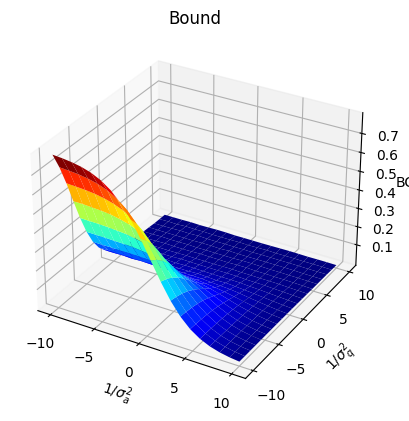

In [5]:
na=1
nq=40
# Evaluate the function on the meshgrid using np.vectorize
x_ = np.logspace(-1,1,20)
y = np.logspace(-1,1,20)
X, Y = np.meshgrid(x_, y)
CRB_vectorized = np.vectorize(CRB_v)
CRB_vals = CRB_vectorized(X, Y,na,nq)

# Create a 3-D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), CRB_vals, cmap='jet')
# Set labels and title
ax.set_xlabel('1/$\sigma_a^2$')
ax.set_ylabel('1/$\sigma_q^2$')
ax.set_zlabel('BCRB')
ax.set_title('Bound')
#ax.set_title('CRB vs. sigma1 and sigma2')

# Show the plot
plt.show()

NameError: name 'Z' is not defined

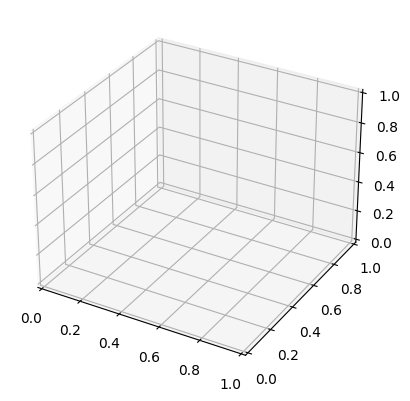

In [6]:
x__ = np.logspace(0,1,20)
y = np.logspace(0,1,20)
X, Y = np.meshgrid(x__, y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), Z-CRB_vals, cmap='jet', alpha=0.8, edgecolor='green')
#ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), CRB_vals, cmap='jet',edgecolor='red')
# Set labels and title
ax.set_xlabel('sigma_a')
ax.set_ylabel('sigma_q')
ax.set_zlabel('MSE')
ax.set_title('Estimator - BCRB')
plt.show()

In [19]:
nq = 1
H,G = Matrix(1,nq) #Matrix is not argument
def expected_D(sigma,thresh,observ=sim): #Matrix is not argument
    teta_samp = samp_teta(observ)
    g_teta = G @ teta_samp
    zeta_real = ((math.sqrt(2)/sigma)*(g_teta.real-thresh))
    zeta_im = ((math.sqrt(2)/sigma)*(g_teta.imag-thresh))
    pdf_real = norm.pdf(zeta_real)
    cdf_real = norm.cdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    cdf_im = norm.cdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(cdf_real, (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(cdf_im, (norm.cdf(-zeta_im))))
    d = np.mean(d_vec, axis=1)
    return d[0]

C:\Users\Yaniv\AppData\Local\Temp\ipykernel_14228\94071412.py:12: RuntimeWarning: invalid value encountered in divide
  d_vec = np.divide(np.power(pdf_real, 2), np.multiply(cdf_real, (norm.cdf(-zeta_real)))) + \
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_14228\94071412.py:13: RuntimeWarning: invalid value encountered in divide
  np.divide(np.power(pdf_im, 2), np.multiply(cdf_im, (norm.cdf(-zeta_im))))


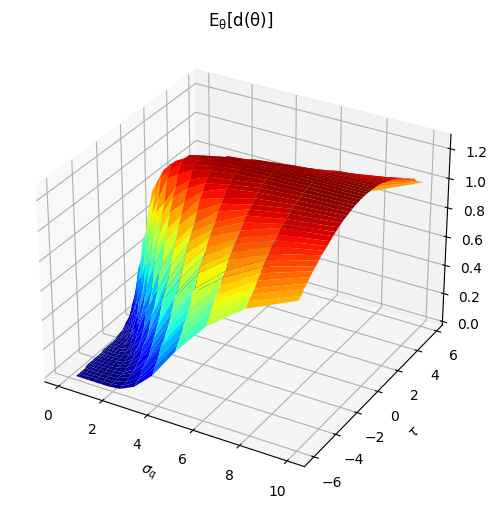

In [93]:
x_ = np.logspace(-1,1,20)
y = np.arange(-6,6,0.25)
X, Y = np.meshgrid(x_, y)
expected_D_vectorized = np.vectorize(expected_D)
expected_D_vals = expected_D_vectorized(X, Y)

# Create a 3-D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, expected_D_vals, cmap='jet')
# Set labels and title
ax.set_xlabel(r'$\sigma_q$')
ax.set_ylabel(r'$\tau$')
ax.set_title(r'$\rm{E}_\theta[d{(\theta)}]$')
#ax.set_title('CRB vs. sigma1 and sigma2')

# Show the plot
plt.show()